Defining the autoencoder module

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras import backend as K
import os

#r'C:\Users\gusta\Documents\KTH\TriOptima\trioptima/'
#'/Users/elliotlindestam/Documents/Skola/Indek icloud/trioptima/'
your_path = r'/Users/elliotlindestam/Documents/Skola/Indek icloud/trioptima/'
folder_path = your_path + '6.Active Data/Train Model Data/'
# Get file in the folder
files = os.listdir(folder_path)

# MAC issue
files = [f for f in files if f != '.DS_Store']
file_name = files[0][:-4]

# Load preprocessed data
file_path = your_path + '4.Scaled/' + file_name +'_Scaled.csv'
data_preprocessed = pd.read_csv(file_path, header=0)

# Convert data to float32
data_preprocessed = data_preprocessed.astype(np.float32)

# Check for inf or NaN values in data
print("Inf values in data: ", np.isinf(data_preprocessed).values.sum())
print("NaN values in data: ", np.isnan(data_preprocessed).values.sum())

# Check to make sure the data is in expected format
try:
    data_preprocessed = data_preprocessed.astype(float)
except ValueError as e:
    print(f"ValueError: {e}")

# Check to make sure the data is in expected format
assert data_preprocessed.applymap(np.isreal).all().all(), "Non-numeric data found"
assert not data_preprocessed.isnull().any().any(), "NaN values found"

# Dimensions
input_dim = data_preprocessed.shape[1]
encoding_dim = int(input_dim / 2)

# Set layer and neurons options
layer_options = [2, 5]
neuron_options = [41, 60]

# Variables to store the best model's configurations and weights
best_val_loss = float('inf')  # Set initial value to infinity
best_num_layers = None
best_num_neurons = None
best_weights = None

# Iterate over neuron configurations
for num_neurons in neuron_options:
    # Iterate over layer configurations
    for num_layers in layer_options:
        K.clear_session()

        input_layer = layers.Input(shape=(input_dim,))
        encoder_layer = layers.Dense(num_neurons, activation='relu')(input_layer)
        
        # Add extra layers based on num_layers
        for _ in range(1, num_layers):
            encoder_layer = layers.Dense(num_neurons, activation='relu')(encoder_layer)

        decoder_layer = layers.Dense(input_dim, activation='sigmoid')(encoder_layer)

        temp_autoencoder = models.Model(inputs=input_layer, outputs=decoder_layer)
        temp_autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        
        history = temp_autoencoder.fit(
            data_preprocessed, data_preprocessed,
            epochs=10, 
            batch_size=32,
            shuffle=True,
            validation_split=0.1
        )
        
        final_val_loss = history.history['val_loss'][-1]
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_num_layers = num_layers
            best_num_neurons = num_neurons
            best_weights = temp_autoencoder.get_weights()

# Construct the best model with configurations
K.clear_session()
input_layer = layers.Input(shape=(input_dim,))
encoder_layer = layers.Dense(best_num_neurons, activation='relu')(input_layer)
for _ in range(1, best_num_layers):
    encoder_layer = layers.Dense(best_num_neurons, activation='relu')(encoder_layer)
decoder_layer = layers.Dense(input_dim, activation='sigmoid')(encoder_layer)

autoencoder = models.Model(inputs=input_layer, outputs=decoder_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Load the best weights into the best model
autoencoder.set_weights(best_weights)

# Display the number of layers and neurons in the best model
print(f"Best Model Configuration:\nNumber of Layers: {best_num_layers}\nNumber of Neurons per Layer: {best_num_neurons}")


Inf values in data:  0
NaN values in data:  0


/var/folders/rq/30rpw85n53d2zxnt_c5qnrx40000gn/T/ipykernel_86679/1844929290.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  assert data_preprocessed.applymap(np.isreal).all().all(), "Non-numeric data found"


Epoch 1/10
51/51 [==============================] - 3s 22ms/step - loss: 84785.8828 - val_loss: 84726.4531
Epoch 2/10
51/51 [==============================] - 0s 7ms/step - loss: 84764.2344 - val_loss: 84726.4453
Epoch 3/10
51/51 [==============================] - 0s 8ms/step - loss: 84764.2656 - val_loss: 84726.4453
Epoch 4/10
51/51 [==============================] - 0s 9ms/step - loss: 84764.2422 - val_loss: 84726.4453
Epoch 5/10
51/51 [==============================] - 0s 6ms/step - loss: 84764.2344 - val_loss: 84726.4453
Epoch 6/10
51/51 [==============================] - 0s 5ms/step - loss: 84764.2422 - val_loss: 84726.4453
Epoch 7/10
51/51 [==============================] - 0s 8ms/step - loss: 84764.2422 - val_loss: 84726.4453
Epoch 8/10
51/51 [==============================] - 0s 7ms/step - loss: 84764.2422 - val_loss: 84726.4453
Epoch 9/10
51/51 [==============================] - 0s 6ms/step - loss: 84764.2500 - val_loss: 84726.4453
Epoch 10/10
51/51 [==========================

Anomaly detection

In [4]:


folder_path = your_path + '6.Active Data/Test Data/'
# Get file in the folder
files = os.listdir(folder_path)

# MAC issue
files = [f for f in files if f != '.DS_Store']
file_name = files[0][:-4]

# Check to make sure the data is in expected format
try:
    data_preprocessed = data_preprocessed.astype(float)
except ValueError as e:
    print(f"ValueError: {e}")

# Check to make sure the data is in expected format
assert data_preprocessed.applymap(np.isreal).all().all(), "Non-numeric data found"
assert not data_preprocessed.isnull().any().any(), "NaN values found"

# Obtain the reconstructed data
predictions = autoencoder.predict(data_preprocessed)

# Measure the reconstruction error
mse = np.mean(np.power(data_preprocessed - predictions, 2), axis=1)

# Convert mse to a DataFrame for easier handling
mse_df = pd.DataFrame({'reconstruction_error': mse})

# Display basic statistics of the error
print(mse_df.describe())


/var/folders/rq/30rpw85n53d2zxnt_c5qnrx40000gn/T/ipykernel_86679/3229174194.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  assert data_preprocessed.applymap(np.isreal).all().all(), "Non-numeric data found"


57/57 [==============================] - 0s 3ms/step
       reconstruction_error
count           1794.000000
mean           84760.071236
std              684.713448
min            84260.559765
25%            84309.418512
50%            84510.928902
75%            84862.447032
max            87592.741272


Visualize

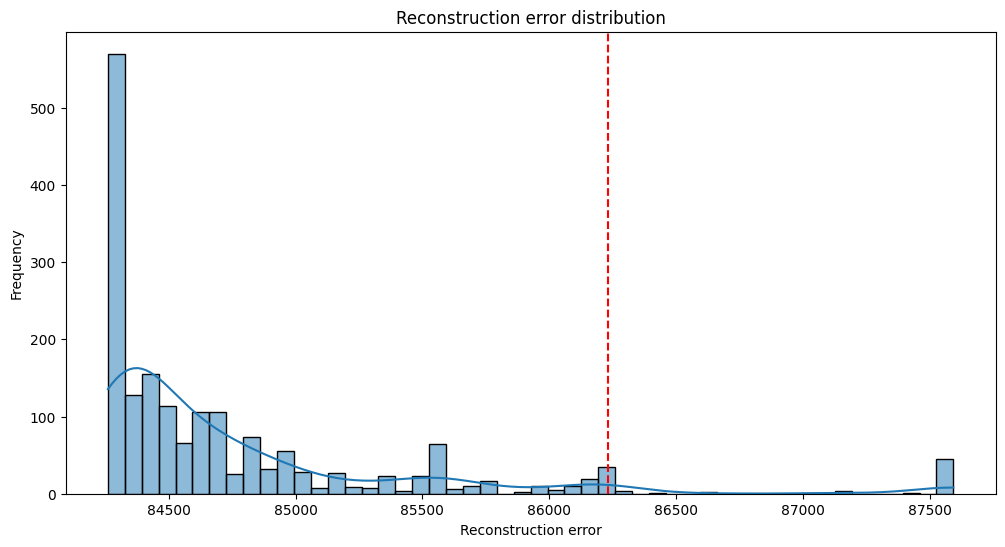

Anomaly threshold: 86232.84332179233


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(mse_df['reconstruction_error'], bins=50, kde=True)
plt.title('Reconstruction error distribution')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')


threshold = np.percentile(mse_df['reconstruction_error'], 95)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.show() 
print(f"Anomaly threshold: {threshold}")



Test new data for outliers

In [13]:
import pandas as pd
import numpy as np

# Set the file paths
folder_path = your_path + '6.Active Data/Test Data/'
# Get file in the folder
files = os.listdir(folder_path)
# MAC issue
files = [f for f in files if f != '.DS_Store']
file_name_test = files[0][:-4]

t_data_path = your_path + '3.Cash_Risk/' + file_name_test +'_Cash_Risk.csv' # THIS IS THE ORIGINAL TEST DATA 
t_data_scaled_path = your_path + '4.Scaled/' + file_name_test + '_Scaled.csv' # THIS IS THE SCALED TEST DATA

# Load new trade data from CSV (both processed and original)
t_data_scaled = pd.read_csv(t_data_scaled_path)
t_data = pd.read_csv(t_data_path)

# Convert data to float32
t_data_scaled = t_data_scaled.astype(np.float32)

# Check for inf or NaN values in data
print("Inf values in data: ", np.isinf(t_data_scaled).values.sum())
print("NaN values in data: ", np.isnan(t_data_scaled).values.sum())

# Check to make sure the data is in expected format
try:
    t_data_scaled = t_data_scaled.astype(float)
except ValueError as e:
    print(f"ValueError: {e}")


# Make sure the autoencoder variable is already defined and trained
# Predict with the autoencoder
new_predictions = autoencoder.predict(t_data_scaled)

# Measure the reconstruction error
new_mse = np.mean(np.power(t_data_scaled - new_predictions, 2), axis=1)
new_mse_df = pd.DataFrame({'reconstruction_error': new_mse})

# Determine whether each trade is an outlier or not
outlier_indices = new_mse_df[new_mse_df['reconstruction_error'] > threshold].index

# Filter the outlier trades from the original data using the outlier indices
outlier_trades_original = t_data.iloc[outlier_indices]

# Save the outlier trades to a CSV file in the original format
outlier_file_path = your_path + '5.Outliers/' + 'Outlier_IRS_test.csv'
outlier_trades_original.to_csv(outlier_file_path, index=False)

print('Number of outlier trades: '+str(len(outlier_trades_original)))
print('See trades in directory: '+outlier_file_path)


Inf values in data:  0
NaN values in data:  0
 1/10 [==>...........................] - ETA: 0s

10/10 [==============================] - 0s 2ms/step
Number of outlier trades: 16
See trades in directory: /Users/elliotlindestam/Documents/Skola/Indek icloud/trioptima/5.Outliers/Outlier_IRS_test.csv
